## LR_(コード共有のため一旦Up)
- 前処理を以下の方法で設定

    - ChestPainType:TAとNAPをTA+NAPにまとめる
    - ST_SlopのFlatとDownをまとめる(FlatとDownの分布が似ている、Downの数が少ない)
    - カテゴリ-変数はOneHotEncoding
    - コレステロール0のデータを区別したいためchol0の特徴量を追加
    - 連続値データは標準化
    - <b>Oldpeak,STSlopを基に特徴量を作成(性別は統合しない)</b>
    - cholesterolをカテゴリー変数にする


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

import optuna

C:\Users\imyme\anaconda3\envs\flask\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#データ取得
df_train = pd.read_csv("../main/data/train.csv")

df_train.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,56,1,ASY,155,342,1,Normal,150,1,3.0,Flat,1
1,55,0,ATA,130,394,0,LVH,150,0,0.0,Up,0
2,47,1,NAP,110,0,1,Normal,120,1,0.0,Flat,1
3,34,1,ASY,115,0,1,Normal,154,0,0.2,Up,1
4,54,0,NAP,160,201,0,Normal,163,0,0.0,Up,0


-Oldpeak,Sex,ST_Slopeで以下の特徴量(H_risk)を作成。元の特徴量は使用しない。<br>
Oldpeakは絶対値で判断<br>
ラベル番号はリスク高い方が大きい<br>
0: -0.3<Oldpeak)<0.3 かつST_Slope=Up,Down<br>
2: -0.3<Oldpeak<0.3 かつST_Slope=Flat<br>
1: 0.3=<Oldpeak<2.5 かつST_Slope=Up<br>
3: 0.3=<Oldpeak<2.5 かつST_Slope=Flat,Down<br>
4: Oldpeak>=2.5 または Oldpeak =<-0.3<br>

In [3]:
#特徴量作成

df_train['H_risk']='HR0'
for i in range(len(df_train)):
    #修正:Downはリスク低い
    if -0.3<df_train.loc[i,'Oldpeak']<0.3 and df_train.loc[i,'ST_Slope']=='Flat':
        df_train.loc[i,'H_risk']='HR2'
    elif 0.3<=df_train.loc[i,'Oldpeak']<2.5 and df_train.loc[i,'ST_Slope']=='Up':
        df_train.loc[i,'H_risk']='HR1'
    elif 0.3<=abs(df_train.loc[i,'Oldpeak'])<2.0 and df_train.loc[i,'ST_Slope']!='Up':
        df_train.loc[i,'H_risk']='HR3'
    elif df_train.loc[i,'Oldpeak']>=2.0 or df_train.loc[i,'Oldpeak']<=-0.3:
        df_train.loc[i,'H_risk']='HR4'
    else:
        pass


In [4]:
#心電図判断検討案2・・不使用
"""
df_train['Shinden']=0
for i in range(len(df_train)):
    if df_train.loc[i,'Oldpeak']<=-0.3:
        df_train.loc[i,'Shinden']=0
    elif df_train.loc[i,'Oldpeak']>=1 and df_train.loc[i,'ST_Slope']!='Up':
        df_train.loc[i,'Shinden']=1
    elif df_train.loc[i,'Oldpeak']>=1.5 and df_train.loc[i,'ST_Slope']=='Up':
        df_train.loc[i,'Shinden']=1   
"""

In [5]:
pd.crosstab(df_train['Shinden'],df_train['HeartDisease'])

HeartDisease,0,1
Shinden,,
0,237,136
1,46,223


In [6]:
#Max_HRについて変換
df_train['MaxHR_2']=207-df_train['Age']*0.7-df_train['MaxHR']

In [7]:
pd.crosstab(df_train['H_risk'],df_train['HeartDisease'])

HeartDisease,0,1
H_risk,,
HR0,187,19
HR1,37,29
HR2,6,75
HR3,43,127
HR4,10,109


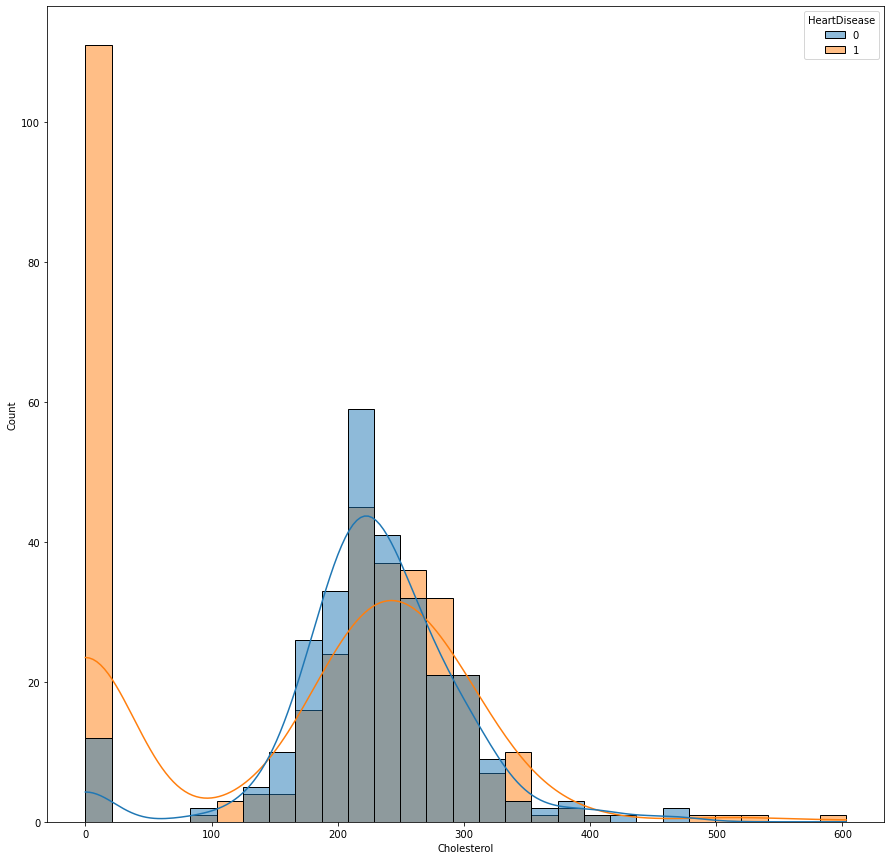

In [8]:
plt.figure(figsize=(15,15))
sns.histplot(df_train,x='Cholesterol',hue='HeartDisease',kde=True)
plt.show()

In [9]:
##cholesterolの特徴量作成:CholCat
#150-220が目安
#220-240が境界値
#それ以降はハイリスク
#240-280,280-320,320以上で区分
df_train['CholCat']='chol0'
for i in range(len(df_train)):
    if 200>df_train.loc[i,'Cholesterol']>0:
        df_train.loc[i,'CholCat']='chol1'
    if 240>df_train.loc[i,'Cholesterol']>=200:
        df_train.loc[i,'CholCat']='chol2'
    elif 280>df_train.loc[i,'Cholesterol']>=240:
        df_train.loc[i,'CholCat']='chol3'
    elif df_train.loc[i,'Cholesterol']>=280:
        df_train.loc[i,'CholCat']='chol4'
    else:
        pass
df_train.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,H_risk,Shinden,MaxHR_2,CholCat
0,56,1,ASY,155,342,1,Normal,150,1,3.0,Flat,1,HR4,1,17.8,chol4
1,55,0,ATA,130,394,0,LVH,150,0,0.0,Up,0,HR0,0,18.5,chol4
2,47,1,NAP,110,0,1,Normal,120,1,0.0,Flat,1,HR2,0,54.1,chol0
3,34,1,ASY,115,0,1,Normal,154,0,0.2,Up,1,HR0,0,29.2,chol0
4,54,0,NAP,160,201,0,Normal,163,0,0.0,Up,0,HR0,0,6.2,chol2


In [10]:
pd.crosstab(df_train['HeartDisease'],df_train['CholCat'])

CholCat,chol0,chol1,chol2,chol3,chol4
HeartDisease,,,,,
0,12,63,93,67,48
1,111,39,77,63,69


In [11]:
#その他の特徴量の前処理

#TAとNAPをTA+NAPとする(分布が似ているかつカテゴリー中のデータ数が少ないため)
df_train.loc[df_train['ChestPainType']=='TA','ChestPainType']='TA+NAP'
df_train.loc[df_train['ChestPainType']=='NAP','ChestPainType']='TA+NAP'
df_train['ChestPainType'].unique()


#OneHotencoder


#ChestPainType,RestingECG,ST_SlopをOneHotEncoding
df_train=df_train.join(pd.get_dummies(df_train['ChestPainType']))
df_train=df_train.join(pd.get_dummies(df_train['RestingECG']))
df_train=df_train.join(pd.get_dummies(df_train['CholCat']))
df_train=df_train.join(pd.get_dummies(df_train['H_risk']))
df_train=df_train.join(pd.get_dummies(df_train['ST_Slope']))

#cholesterol値以外の数値データを標準化

#データ標準化する対象を選択
numeric_features=['Age','RestingBP', 'MaxHR','Cholesterol','Oldpeak','MaxHR_2']

#標準化したデータを元のデータに入れる
#_zで標準化したデータに対応
SS=StandardScaler()
df_train[['Age_z','RestingBP_z','MaxHR_z','Cholesterol_z','Oldpeak_z','MaxHR_2_z']]=SS.fit_transform(df_train[numeric_features].values)

df_train.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,...,HR4,Down,Flat,Up,Age_z,RestingBP_z,MaxHR_z,Cholesterol_z,Oldpeak_z,MaxHR_2_z
0,56,1,ASY,155,342,1,Normal,150,1,3.0,...,1,0,1,0,0.256306,1.272672,0.512265,1.323176,1.959903,-0.628610
1,55,0,ATA,130,394,0,LVH,150,0,0.0,...,0,0,0,1,0.151431,-0.116784,0.512265,1.796972,-0.809353,-0.597872
2,47,1,TA+NAP,110,0,1,Normal,120,1,0.0,...,0,0,1,0,-0.687567,-1.228348,-0.706992,-1.792941,-0.809353,0.965409
3,34,1,ASY,115,0,1,Normal,154,0,0.2,...,0,0,0,1,-2.050938,-0.950457,0.674833,-1.792941,-0.624736,-0.128009
4,54,0,TA+NAP,160,201,0,Normal,163,0,0.0,...,0,0,0,1,0.046557,1.550563,1.040610,0.038461,-0.809353,-1.137994


In [12]:
#カラム一覧
df_train.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease', 'H_risk', 'Shinden', 'MaxHR_2', 'CholCat', 'ASY', 'ATA',
       'TA+NAP', 'LVH', 'Normal', 'ST', 'chol0', 'chol1', 'chol2', 'chol3',
       'chol4', 'HR0', 'HR1', 'HR2', 'HR3', 'HR4', 'Down', 'Flat', 'Up',
       'Age_z', 'RestingBP_z', 'MaxHR_z', 'Cholesterol_z', 'Oldpeak_z',
       'MaxHR_2_z'],
      dtype='object')

In [59]:
#データフレーム選択
#df_train = df_train.copy().query('Cholesterol!=0').reset_index()
#df_train2=df_train.query('Cholesterol == 0').copy()
#df_train2.shape

(123, 44)

In [61]:
#df_train=df_train2.reset_index(drop=True)

- B1: 元の特徴量全てで予測
- B2: ChestPainTypeを除く
- 案1: Cholesterol=0をダミー変数として採用した特徴量(chol=0)を採用
- 案2: 案1+Cholesterol削除

In [14]:
#特徴量と目的変数のカラム名
features1 = ['Age_z','Sex','RestingBP_z','Cholesterol_z','FastingBS','MaxHR_z', 'ExerciseAngina','Oldpeak_z','LVH','Normal','ST', 'ASY', 'NAP', 'TA+ATA','Down', 'Flat', 'Up']
features2 = ['Age_z','Sex','RestingBP_z','Cholesterol_z','FastingBS','MaxHR_z', 'ExerciseAngina','Oldpeak_z','LVH','Normal','ST', 'Down', 'Flat', 'Up']
features3 = ['Age_z','Sex','RestingBP_z','Cholesterol_z','FastingBS','MaxHR_z', 'ExerciseAngina','Oldpeak_z','LVH','Normal','ST', 'Down', 'Flat', 'Up','chol0']
features_a2 = ['Age_z','Sex','RestingBP_z','FastingBS','MaxHR_z', 'ExerciseAngina','Oldpeak_z','LVH','Normal','ST', 'Down', 'Flat', 'Up','chol0','chol1','chol2','chol3','chol4']
features_a2_n0 = ['Age_z','Sex','RestingBP_z','FastingBS','MaxHR_z', 'ExerciseAngina','Oldpeak_z','LVH','Normal','ST', 'Down', 'Flat', 'Up','chol1','chol2','chol3','chol4']
features_a3 = ['Age_z','Sex','RestingBP_z','FastingBS','MaxHR_z', 'ExerciseAngina','LVH','Normal','ST','chol0','chol1','chol2','chol3','chol4','HR0','HR1', 'HR2', 'HR3', 'HR4']
features_a3_n0 = ['Age_z','Sex','RestingBP_z','FastingBS','MaxHR_z', 'ExerciseAngina','LVH','Normal','ST','chol1','chol2','chol3','chol4','HR0','HR1', 'HR2', 'HR3', 'HR4']
features_a4 = ['Age_z','Sex','RestingBP_z','FastingBS','MaxHR_z', 'ExerciseAngina','LVH','chol0','chol1','chol2','chol3','chol4','HR0','HR1', 'HR2', 'HR3', 'HR4']
features_a5 = ['Age_z','Sex','FastingBS','MaxHR_z', 'ExerciseAngina','LVH','chol0','chol1','chol2','chol3','chol4','HR0','HR1', 'HR2', 'HR3', 'HR4','high_BP']
#BPの項目無くす
features_a6 = ['Age_z','Sex','FastingBS','MaxHR_z', 'ExerciseAngina','LVH','chol0','chol1','chol2','chol3','chol4','HR0','HR1', 'HR2', 'HR3', 'HR4']
#ChestPainType入れてみる(TA+ATA or ASY)
features_a7 = ['ASY','Age_z','Sex','FastingBS','MaxHR_z', 'ExerciseAngina','LVH','chol0','chol1','chol2','chol3','chol4','HR0','HR1', 'HR2', 'HR3', 'HR4']

#a4からMaxHRを変える
features_a4_2 = ['Age_z','Sex','RestingBP_z','FastingBS','MaxHR_2_z', 'ExerciseAngina','LVH','chol0','chol1','chol2','chol3','chol4','HR0','HR1', 'HR2', 'HR3', 'HR4']

#chol_catの1-3をなくす
features_a4_3 = ['Age_z','Sex','RestingBP_z','FastingBS','MaxHR_2_z', 'ExerciseAngina','LVH','chol0','chol4','HR0','HR1', 'HR2', 'HR3', 'HR4']
features_a4_4 = ['Age_z','Sex','RestingBP_z','FastingBS','MaxHR_2_z', 'ExerciseAngina','LVH','chol0','chol3','chol4','HR0','HR1', 'HR2', 'HR3', 'HR4']
#a4からH_riskの変更
features_a7 = ['Age_z','Sex','RestingBP_z','FastingBS','MaxHR_2_z', 'ExerciseAngina','LVH','chol0','chol3','chol4','Risk0', 'Risk1', 'Risk2', 'Risk3', 'Risk4', 'Risk5']

#論文の心電図の判定方法を反映
features_a8 = ['Age_z','Sex','RestingBP_z','FastingBS','MaxHR_z', 'ExerciseAngina','LVH','chol0','Shinden','Cholesterol_z','Down', 'Flat', 'Up','Oldpeak_z']

#features4 = ['Age_z','Sex','RestingBP_z','Cholesterol_z','FastingBS','MaxHR_z', 'ExerciseAngina','Oldpeak_z','LVH','Normal','ST', 'chol0','HR0', 'HR1', 'HR2','HR3', 'HR4']
target = "HeartDisease"

In [15]:
#ロジスティック回帰
#モデル作成
LR = LogisticRegression(C=0.7, penalty='l2',class_weight='balanced')#LogisticRegression(class_weight='balanced',max_iter=10000,C=5)

#特徴量選択
features=features_a4_3

#5分割公差検証
#変数
X_LR = df_train[features]
Y = df_train[target]

#交差検証
score_LR = cross_val_score(LR, X_LR, Y, cv=5)  

#正解率を出力する
print(f"スコア LC 交差バージョン: {score_LR}")
print("")

#平均値を出力する
print(f"平均値 LC 交差バージョン： {score_LR.mean()}")
print("")

スコア LC 交差バージョン: [0.86821705 0.89147287 0.921875   0.8671875  0.875     ]

平均値 LC 交差バージョン： 0.8847504844961239



In [16]:
#それぞれの特徴量の係数
LR.fit(X_LR,Y)

#結果を入れるためのDataFrame
df_coef=pd.DataFrame()

for i in range(len(features)):
    #print(features[i],':',LR.coef_[0,i])
    df_coef.loc[i,'features']=features[i]
    df_coef.loc[i,'coef']=LR.coef_[0,i]

#降順に並べる
df_coef=df_coef.sort_values('coef',ascending=False)

In [17]:
df_coef.coef.values

array([ 1.60697821,  1.50787782,  1.26631085,  1.21553394,  1.19147285,
        0.75746961,  0.48350584,  0.42136908,  0.35765364,  0.23749928,
        0.10688194,  0.03447263, -0.79784089, -2.13154177])

In [18]:
df_train.describe()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,Shinden,...,HR4,Down,Flat,Up,Age_z,RestingBP_z,MaxHR_z,Cholesterol_z,Oldpeak_z,MaxHR_2_z
count,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,...,642.000000,642.000000,642.000000,642.000000,6.420000e+02,6.420000e+02,6.420000e+02,6.420000e+02,6.420000e+02,6.420000e+02
mean,53.556075,0.786604,132.101246,196.778816,0.247664,137.395639,0.389408,0.876791,0.559190,0.419003,...,0.185358,0.076324,0.492212,0.431464,1.833511e-16,-4.033205e-16,-2.730595e-16,1.333305e-16,-1.988717e-17,-1.884526e-16
std,9.542620,0.410024,18.006691,109.837553,0.431992,24.624338,0.487996,1.084168,0.496871,0.493781,...,0.388891,0.265723,0.500329,0.495667,1.000780e+00,1.000780e+00,1.000780e+00,1.000780e+00,1.000780e+00,1.000780e+00
min,28.000000,0.000000,80.000000,0.000000,0.000000,67.000000,0.000000,-2.600000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-2.680187e+00,-2.895694e+00,-2.861012e+00,-1.792941e+00,-3.209376e+00,-2.262150e+00
25%,47.000000,1.000000,120.000000,172.000000,0.000000,120.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-6.875666e-01,-6.725657e-01,-7.069917e-01,-2.257710e-01,-8.093534e-01,-7.855970e-01
50%,54.000000,1.000000,130.000000,222.000000,0.000000,139.000000,0.000000,0.500000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,4.655654e-02,-1.167835e-01,6.520428e-02,2.298016e-01,-3.478106e-01,-4.238022e-02
75%,61.000000,1.000000,140.000000,264.000000,0.000000,156.000000,1.000000,1.500000,1.000000,1.000000,...,0.000000,0.000000,1.000000,1.000000,7.806797e-01,4.389986e-01,7.561165e-01,6.124827e-01,5.752750e-01,7.282818e-01
max,77.000000,1.000000,200.000000,603.000000,1.000000,194.000000,1.000000,6.200000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,2.458675e+00,3.773692e+00,2.300508e+00,3.701265e+00,4.913777e+00,2.866814e+00


In [19]:
LR.intercept_

array([-1.6089135])

In [ ]:
d

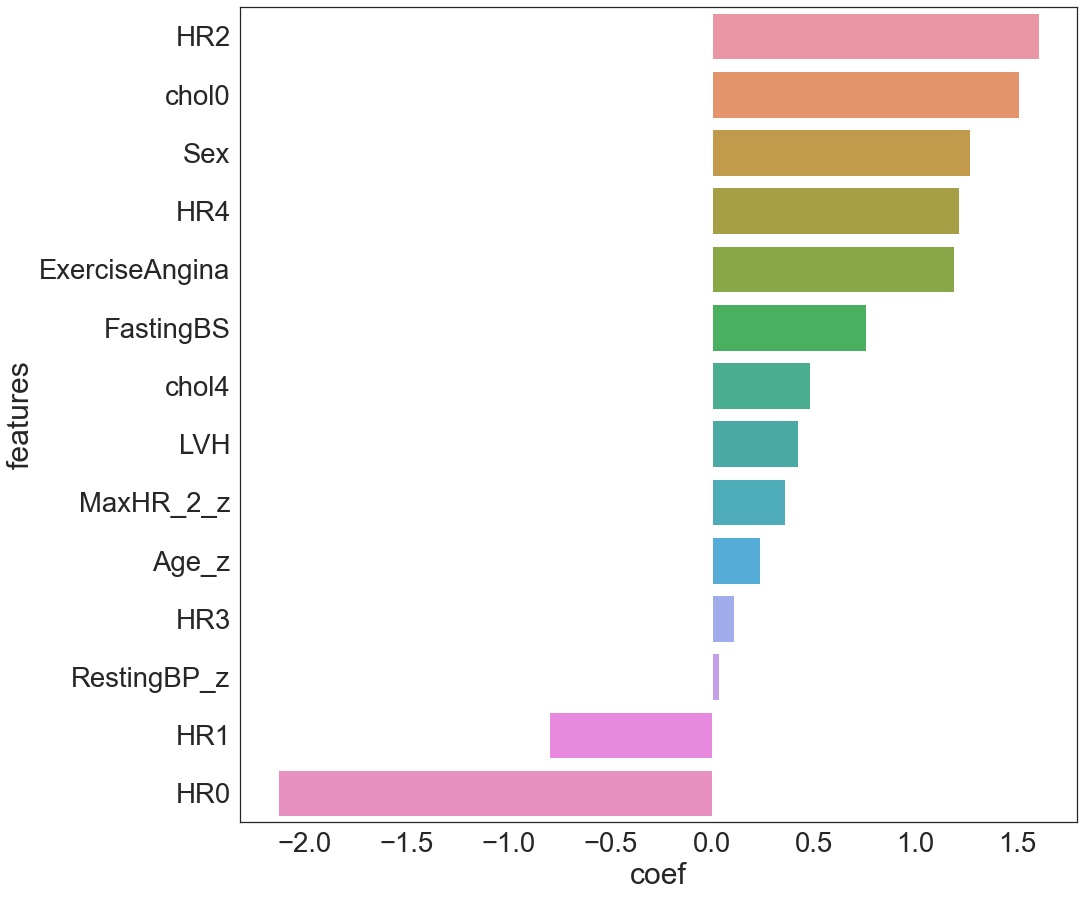

In [20]:
plt.figure(figsize=(15,15))
sns.set(font_scale=2.5,style='white',palette='bright')
sns.barplot(df_coef,x='coef',y='features')
plt.show()

In [21]:
#データ取得用公差検証

#Kfoldでtrainとtestのindexを取得
kf = KFold(n_splits=5,shuffle=True,random_state=82)

#df_trainの行を準備
df_train[['LR_prob','LR_pred']]=0

val_pred=[]
val_lists=[]
val_pred_acc=[]

#foldした分だけpredictを回す(公差検証)
for i,(train_index,val_index) in enumerate(kf.split(df_train)):
    
    #validationのindexを取得
    val_lists.append(val_index)
    
    #それぞれのモデルのfit
    LR.fit(X_LR.loc[train_index,:],Y[train_index])

    #それぞれのモデルでtestをpredict_prabaして確率を保存
    LR_proba=LR.predict_proba(X_LR.loc[val_index,:])
    
    #df_trainに心臓病確率を入れる
    df_train.loc[val_index,'LR_prob']=LR_proba[:,1]

    #df_trainに心臓病予測を入れる
    df_train.loc[val_index,'LR_pred']=LR.predict(X_LR.loc[val_index,:])
    
    #正答率をリストに入れる
    val_pred_acc.append(accuracy_score(df_train.loc[val_index,'HeartDisease'].values,df_train.loc[val_index,'LR_pred'].values))
    

    
#公差検証の結果
print('5分割:',val_pred_acc)
print('5分割平均:',sum(val_pred_acc)/len(val_pred_acc))

#データ全体の正答率
print('全体:',accuracy_score(df_train['HeartDisease'].values,df_train['LR_pred'].values))

5分割: [0.8914728682170543, 0.8914728682170543, 0.8984375, 0.9296875, 0.84375]
5分割平均: 0.8909641472868216
全体: 0.8909657320872274


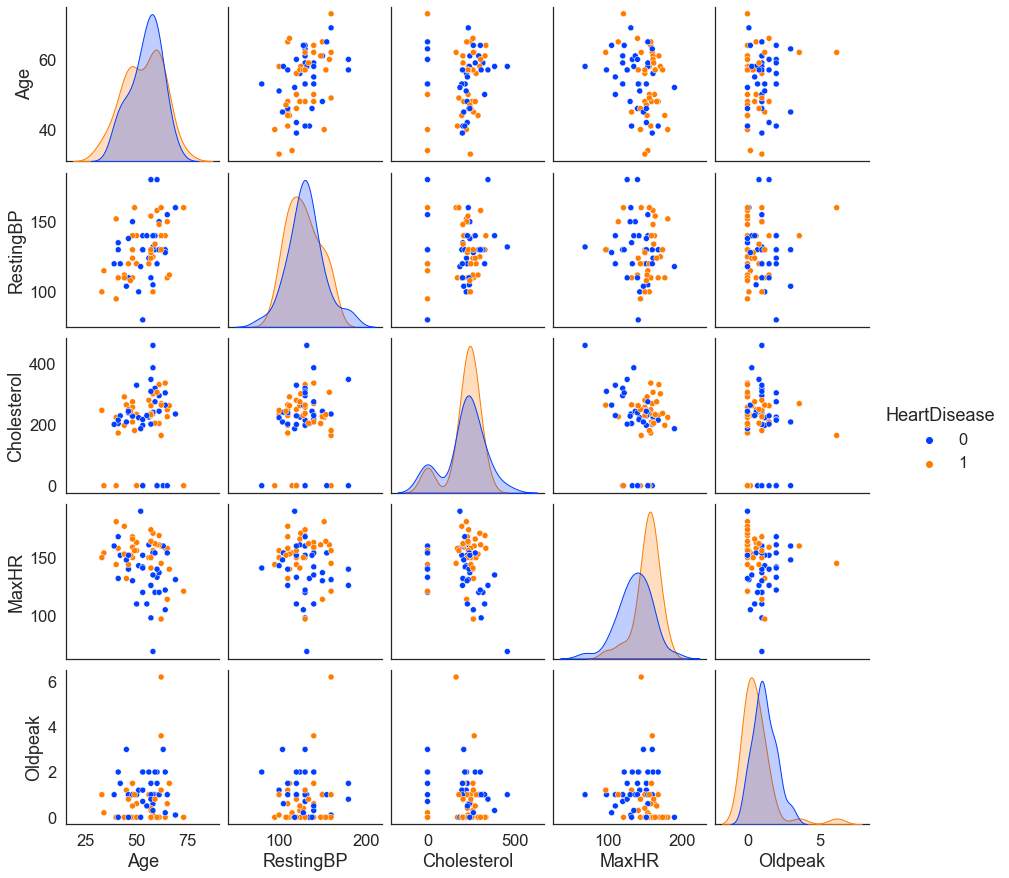

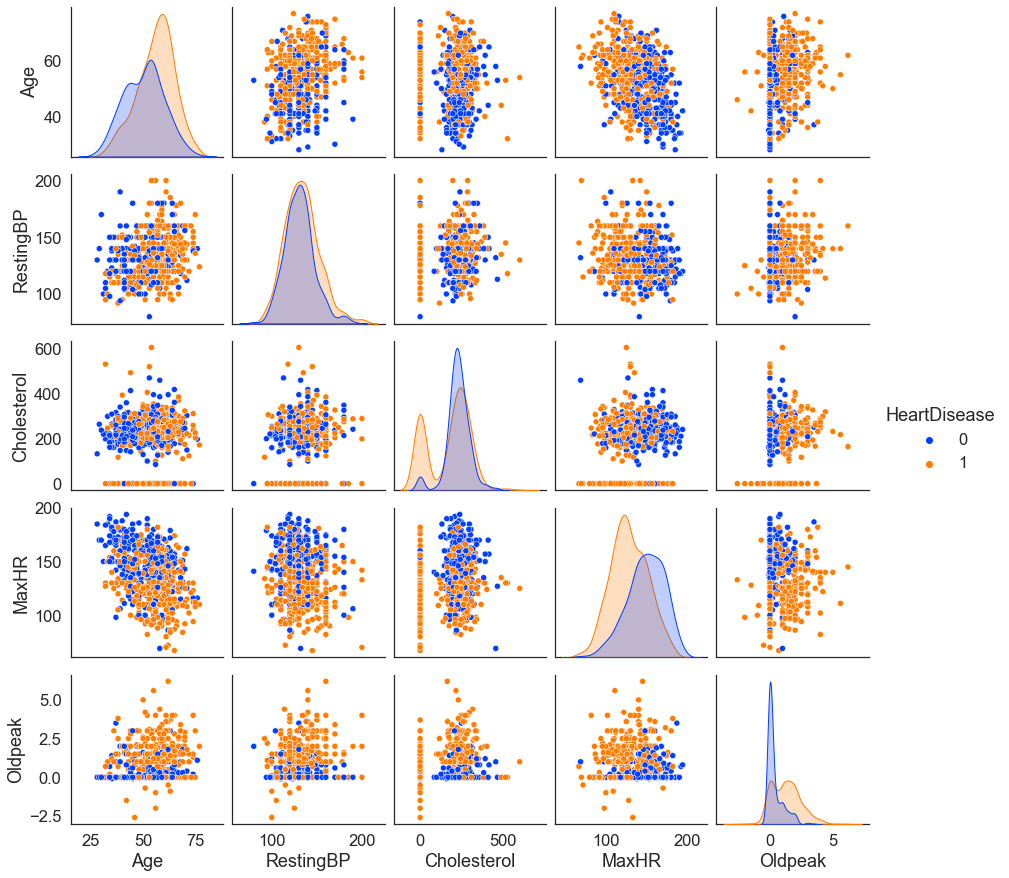

In [22]:
#正解の場合"1"になる列を作成

#seabornのグラフ設定
sns.set(font_scale=1.5,style='white',palette='bright')

df_train['ACC_LR']=0
for i in range(len(df_train)):
    if df_train.loc[i,'HeartDisease']==df_train.loc[i,'LR_pred']:
        df_train.loc[i,'ACC_LR']=1
    else:
        pass


#間違いだけのデータフレーム作成
df_train_wrong=df_train.copy()
df_train_wrong=df_train_wrong.query('ACC_LR==0')

#pairplotの作成,心臓病のありなしで色分け
sns.pairplot(df_train_wrong,vars=['Age','RestingBP','Cholesterol','MaxHR','Oldpeak'],hue='HeartDisease')

#図を保存する場合に実行
#plt.savefig('./WrongAnswers/LR_dummy1.png')

#比較用に、元データのpairplotも表示
sns.pairplot(df_train,vars=['Age','RestingBP','Cholesterol','MaxHR','Oldpeak'],hue='HeartDisease')
plt.show()

In [27]:
df_train_wrong.query('Oldpeak>5')

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,...,Up,Age_z,RestingBP_z,MaxHR_z,Cholesterol_z,Oldpeak_z,MaxHR_2_z,LR_prob,LR_pred,ACC_LR
611,62,0,ASY,160,164,0,LVH,145,0,6.2,...,0,0.885554,1.550563,0.309056,-0.298663,4.913777,-0.59348,0.480513,0,0


In [23]:
#予測と正解のクロス集計表
pd.crosstab(df_train['HeartDisease'],df_train['LR_pred'])

LR_pred,0,1
HeartDisease,,
0,249,34
1,36,323


In [152]:
#STとHR
pd.crosstab(df_train['RestingECG'],df_train['H_risk'])

H_risk,HR0,HR1,HR2,HR3,HR4
RestingECG,,,,,
LVH,31,15,12,46,17
Normal,141,38,56,132,30
ST,34,13,13,48,16


In [11]:
#Resting BPが気になる
df_train['high_BP']=0
for i in range(len(df_train)):
    if df_train.loc[i,'RestingBP']>130:
        df_train.loc[i,'high_BP']=1
    else:
        pass
pd.crosstab(df_train['high_BP'],df_train['HeartDisease'])

HeartDisease,0,1
high_BP,,
0,164,183
1,119,176


In [71]:
df_train.query('Oldpeak==0').query('Cholesterol==0')

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
2,47,1,NAP,110,0,1,Normal,120,1,0.0,Flat,1
18,51,1,ASY,130,0,1,ST,163,0,0.0,Flat,1
32,66,0,ASY,155,0,1,Normal,90,0,0.0,Flat,1
47,40,1,ASY,95,0,1,ST,144,0,0.0,Up,1
50,56,1,ASY,120,0,0,ST,148,0,0.0,Flat,1
53,40,1,ASY,125,0,1,Normal,165,0,0.0,Flat,1
86,69,1,ASY,135,0,0,Normal,130,0,0.0,Flat,1
146,54,1,ASY,120,0,0,Normal,155,0,0.0,Flat,1
170,53,1,ATA,120,0,0,Normal,95,0,0.0,Flat,1
185,38,1,ASY,135,0,1,Normal,150,0,0.0,Flat,1


## 案1:ChestPainTypeの除外 (こっちをベンチマークすべき?)

In [ ]:
#特徴量と目的変数のカラム名


## 案2:コレステロール0のダミー変数"chol0"を作成、コレステロールは廃止

In [ ]:
#特徴量と目的変数のカラム名
features = ['Age_z','Sex','RestingBP_z','FastingBS','MaxHR_z', 'ExerciseAngina','chol0','chol1', 'chol2', 'Risk0', 'Risk1', 'Risk2', 'Risk4']
target = "HeartDisease"

In [7]:
#特徴量と目的変数のカラム名
features = ['Age_z','Sex','RestingBP_z','FastingBS','MaxHR_z', 'ExerciseAngina','chol0','chol1', 'chol2', 'Risk0', 'Risk1', 'Risk2', 'Risk4']
target = "HeartDisease"

In [67]:
#ロジスティック回帰
#モデル作成
LR = LogisticRegression(C=1.5, solver='liblinear',class_weight='balanced',random_state=82, penalty='l2')#LogisticRegression(class_weight='balanced',max_iter=10000,C=5)

#5分割公差検証
#変数
X_LR = df_train[features]
Y = df_train[target]

#交差検証
score_LR = cross_val_score(LR, X_LR, Y, cv=5)  

#正解率を出力する
print(f"スコア LC 交差バージョン: {score_LR}")
print("")

#平均値を出力する
print(f"平均値 LC 交差バージョン： {score_LR.mean()}")
print("")

スコア LC 交差バージョン: [0.88372093 0.89147287 0.90625    0.8671875  0.890625  ]

平均値 LC 交差バージョン： 0.8878512596899224



In [ ]:
スコア LC 交差バージョン: [0.88372093 0.88372093 0.9140625  0.8671875  0.890625  ]

平均値 LC 交差バージョン： 0.8878633720930231

In [72]:
#データ取得用公差検証

#Kfoldでtrainとtestのindexを取得
kf = KFold(n_splits=5,shuffle=True,random_state=200)

#df_trainの行を準備
df_train[['LR_prob','LR_pred']]=0

val_pred=[]
val_lists=[]
val_pred_acc=[]

#foldした分だけpredictを回す(公差検証)
for i,(train_index,val_index) in enumerate(kf.split(df_train)):
    
    #validationのindexを取得
    val_lists.append(val_index)
    
    #それぞれのモデルのfit
    LR.fit(X_LR.loc[train_index,:],Y[train_index])

    #それぞれのモデルでtestをpredict_prabaして確率を保存
    LR_proba=LR.predict_proba(X_LR.loc[val_index,:])
    
    #df_trainに心臓病確率を入れる
    df_train.loc[val_index,'LR_prob']=LR_proba[:,1]

    #df_trainに心臓病予測を入れる
    df_train.loc[val_index,'LR_pred']=LR.predict(X_LR.loc[val_index,:])
    
    #正答率をリストに入れる
    val_pred_acc.append(accuracy_score(df_train.loc[val_index,'HeartDisease'].values,df_train.loc[val_index,'LR_pred'].values))
    

    
#公差検証の結果
print('5分割:',val_pred_acc)
print('5分割平均:',sum(val_pred_acc)/len(val_pred_acc))

#データ全体の正答率
print('全体:',accuracy_score(df_train['HeartDisease'].values,df_train['LR_pred'].values))

5分割: [0.8372093023255814, 0.8527131782945736, 0.859375, 0.8125, 0.9140625]
5分割平均: 0.8551719961240309
全体: 0.8551401869158879


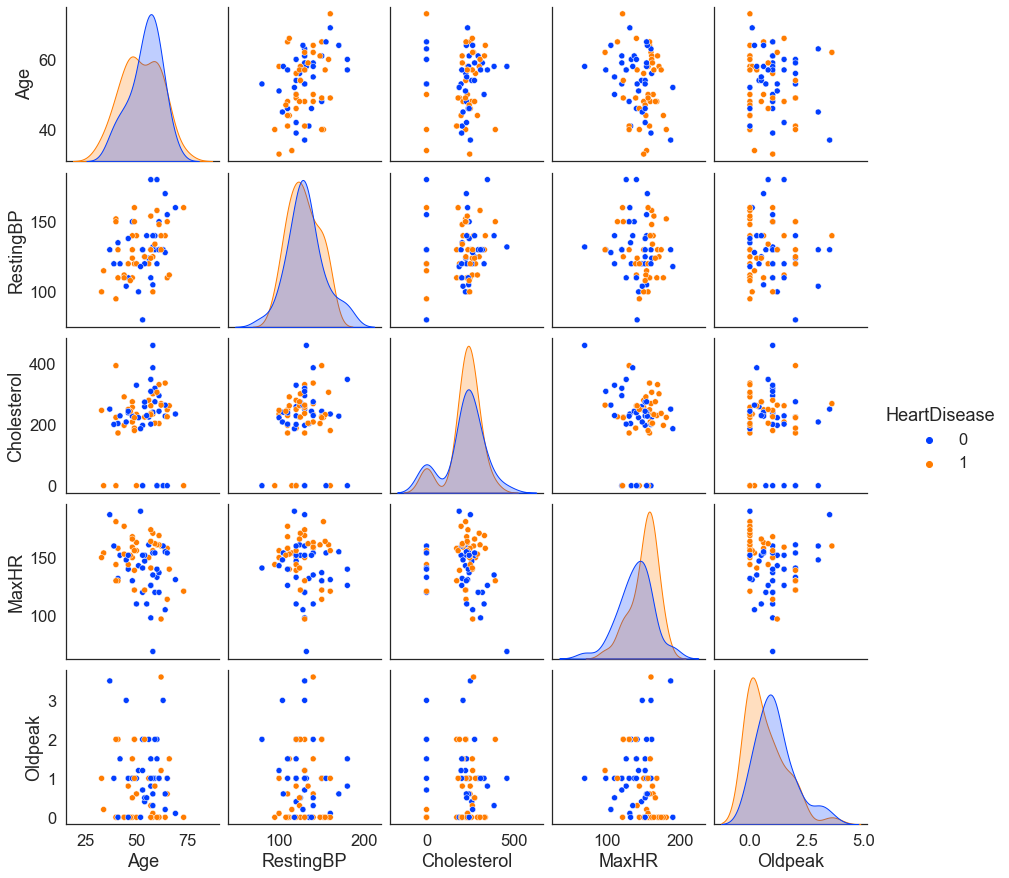

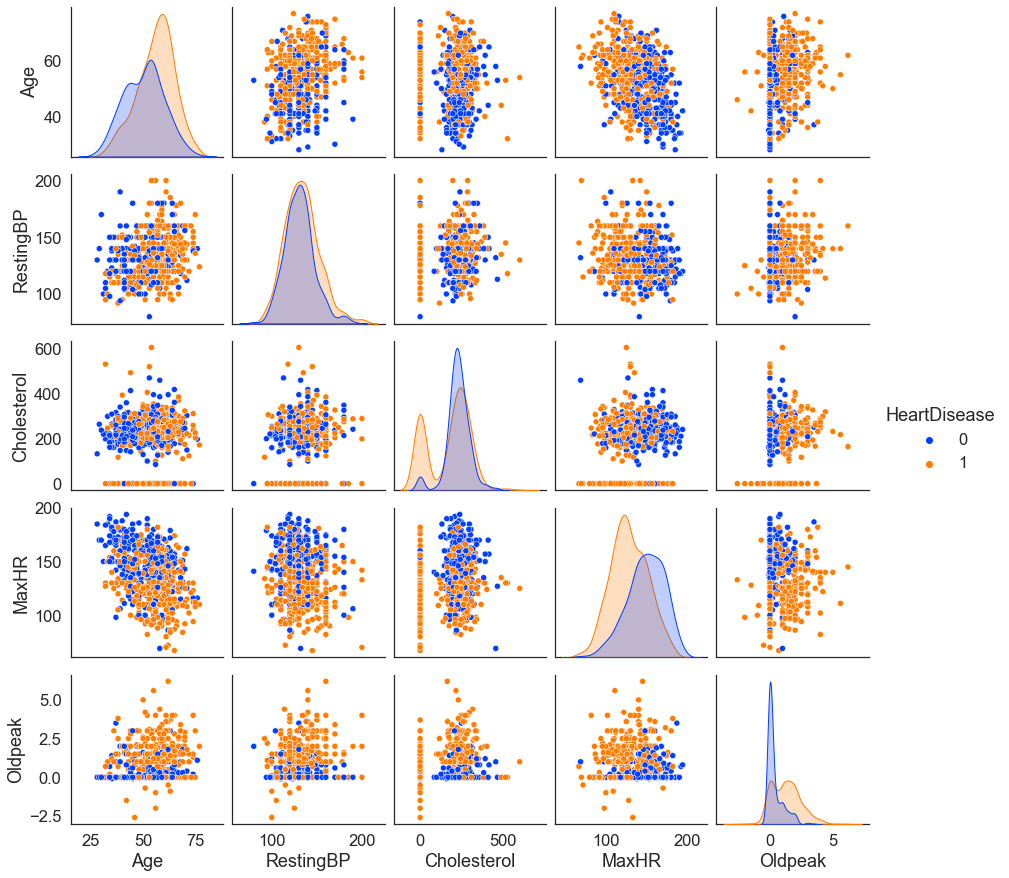

In [69]:
#正解の場合"1"になる列を作成

#seabornのグラフ設定
sns.set(font_scale=1.5,style='white',palette='bright')

df_train['ACC_LR']=0
for i in range(len(df_train)):
    if df_train.loc[i,'HeartDisease']==df_train.loc[i,'LR_pred']:
        df_train.loc[i,'ACC_LR']=1
    else:
        pass


#間違いだけのデータフレーム作成
df_train_wrong=df_train.copy()
df_train_wrong=df_train_wrong.query('ACC_LR==0')

#pairplotの作成,心臓病のありなしで色分け
sns.pairplot(df_train_wrong,vars=['Age','RestingBP','Cholesterol','MaxHR','Oldpeak'],hue='HeartDisease')

#図を保存する場合に実行
#plt.savefig('./WrongAnswers/LR_dummy1.png')

#比較用に、元データのpairplotも表示
sns.pairplot(df_train,vars=['Age','RestingBP','Cholesterol','MaxHR','Oldpeak'],hue='HeartDisease')
plt.show()

In [70]:
#予測と正解のクロス集計表
pd.crosstab(df_train['HeartDisease'],df_train['LR_pred'])

LR_pred,0,1
HeartDisease,,
0,248,35
1,38,321


## テスト

In [18]:
#特徴量作成
df_test['H_risk']='Risk0'
for i in range(len(df_test)):
    #修正:Downはリスク低い
    if -0.3<df_test.loc[i,'Oldpeak']<0.3 and df_test.loc[i,'ST_Slope']=='Flat':
        df_test.loc[i,'H_risk']='Risk2'
    elif 0.3<=df_test.loc[i,'Oldpeak']<2.5 and df_test.loc[i,'ST_Slope']=='Up':
        df_test.loc[i,'H_risk']='Risk1'
    elif 0.3<=abs(df_test.loc[i,'Oldpeak'])<2.5 and df_test.loc[i,'ST_Slope']!='Up':
        df_test.loc[i,'H_risk']='Risk3'
    elif df_test.loc[i,'Oldpeak']>=2.5 or df_test.loc[i,'Oldpeak']<=-0.3:
        df_test.loc[i,'H_risk']='Risk4'
    else:
        pass


##cholesterolの特徴量作成:CholCat
df_test['CholCat']='chol0'
for i in range(len(df_test)):
    if 200>df_test.loc[i,'Cholesterol']>0:
        df_test.loc[i,'CholCat']='chol1'
    elif 320>df_test.loc[i,'Cholesterol']>=200:
        df_test.loc[i,'CholCat']='chol2'
    elif df_test.loc[i,'Cholesterol']>=320:
        df_test.loc[i,'CholCat']='chol3'
    else:
        pass


#その他の特徴量の前処理

#TAとNAPをTA+NAPとする(分布が似ているかつカテゴリー中のデータ数が少ないため)
df_test.loc[df_test['ChestPainType']=='TA','ChestPainType']='TA+NAP'
df_test.loc[df_test['ChestPainType']=='NAP','ChestPainType']='TA+NAP'
df_test['ChestPainType'].unique()

#コレステロールが0の場合の特徴量を作成
"""
df_test['chol0']= 0
for i in range(len(df_test)):
    if df_test.loc[i,'Cholesterol']==0:
        df_test.loc[i,'chol0']=1
    else:
        pass
"""


#OneHotencoder

#-----------ここを変更-----------------------------------------------

#ChestPainType,RestingECG,ST_SlopをOneHotEncoding
df_test=df_test.join(pd.get_dummies(df_test['ChestPainType']))
df_test=df_test.join(pd.get_dummies(df_test['RestingECG']))
df_test=df_test.join(pd.get_dummies(df_test['CholCat']))
df_test=df_test.join(pd.get_dummies(df_test['H_risk']))

#不要列を削除
#df_test=df_test.drop(columns=['ChestPainType','RestingECG','CholCat','H_risk'])



#Old peakはマイナスの時にその絶対値で代替する
#df_test.loc[df_test['Oldpeak']<0,'Oldpeak']=abs(df_test.loc[df_test['Oldpeak']<0,'Oldpeak'])

#cholesterol値以外の数値データを標準化

#データ標準化する対象を選択
numeric_features=['Age','RestingBP', 'MaxHR']

#標準化したデータを元のデータに入れる
#_zで標準化したデータに対応
SS=StandardScaler()
df_test[['Age_z','RestingBP_z','MaxHR_z']]=SS.transform(df_test[numeric_features].values)


NameError: name 'df_test' is not defined

In [ ]:
X_test=df_test[features]
y_test = df_test[target]

clf_LC = LogisticRegression(C=0.7, penalty='l2')
clf_LC.train(X)
y_test= clf_LC.predict(X_test)

accuracy_score(y_test)

## ハイパラ調整

In [28]:
## Optuna


#クラス作成
class Objective():
    def __init__(self, X, y):
        # 変数X,yの初期化
        self.X = X
        self.y = y

    def __call__(self, trial):
        # ハイパーパラメータの設定
        params = {
            # 最適化アルゴリズムを指定
            'solver' : 'liblinear',
            # 正則化の強さを指定（0.0001から10まで）
            'C': trial.suggest_float('C', 0.001, 5),
            # 正則化の種類(elastic netは別枠でやる)
            'penalty':'l2',
            #'penalty':trial.suggest_categorical('penalty',['l1','l2']),
            'random_state':82,
            'class_weight':'balanced'
            }

        model = LogisticRegression(**params)

        # 評価指標として正解率の最大化を目指す
        scores = cross_validate(model,
                                X=self.X, 
                                y=self.y,
                                scoring='accuracy', # 正解率を指定（https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter）
                                n_jobs=-1) # 並行して実行するジョブの数（-1は全てのプロセッサを使用）
        return scores['test_score'].mean()


    
    
    

In [29]:
objective = Objective(X_LR, Y)
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize') # 最大化
study.optimize(objective,n_trials=300)

# ベストパラメータを出力
print('params:', study.best_params)
print('score:', study.best_value)

params: {'C': 4.847861458411895}
score: 0.8878633720930231


params: {'C': 0.6191204232710368, 'max_iter': 26674, 'penalty': 'l2'}
score: 0.889437984496124

In [ ]:
params: {'C': 1.5695840699274808, 'penalty': 'l2'}

params: {'C': 0.6191204232710368, 'max_iter': 26674, 'penalty': 'l2'} score: 0.889437984496124

In [28]:
#クラス作成
class Objective():
    def __init__(self, X, y):
        # 変数X,yの初期化
        self.X = X
        self.y = y

    def __call__(self, trial):
        # ハイパーパラメータの設定
        params = {
            # 最適化アルゴリズムを指定
            'solver' : 'saga',
            # 正則化の強さを指定（0.0001から10まで）
            'C': trial.suggest_float('C', 0.001, 5),
            # 最大反復回数（＊ソルバーが収束するまで）
            'max_iter': trial.suggest_int('max_iter', 100, 100000),
            # 正則化の種類(elastic netは別枠でやる)
            'penalty':'elasticnet',
            # elastic netの係数
            'l1_ratio':trial.suggest_float('l1_ratio', 0.001, 0.999)
            }

        model = LogisticRegression(**params)

        # 評価指標として正解率の最大化を目指す
        scores = cross_validate(model,
                                X=self.X, 
                                y=self.y,
                                scoring='accuracy', # 正解率を指定（https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter）
                                n_jobs=-1) # 並行して実行するジョブの数（-1は全てのプロセッサを使用）
        return scores['test_score'].mean()



In [29]:
objective = Objective(X, Y)
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize') # 最大化
study.optimize(objective,timeout=120)

# ベストパラメータを出力
print('params:', study.best_params)
print('score:', study.best_value)

params: {'C': 0.7651925187788763, 'max_iter': 22397, 'l1_ratio': 0.8898929969550153}
score: 0.8863372093023255


params: {'C': 0.7384006850395533, 'max_iter': 63733, 'penalty': 'l2'}
score: 0.8878875968992247

## 結構上がった！

In [20]:
#予測結果の確認
#データをランダムに250個抽出してfitさせる
rng = np.random.default_rng()
train_index=rng.permutation(len(X))[:280]

clf_LC.fit(X.loc[train_index,:],Y[train_index])

#train以外のindexを持ってくる
all_index=np.arange(len(X))
mask=np.in1d(all_index,train_index,invert=True)
test_index=all_index[mask]

#テストスコアを確認
y_pred=clf_LC.predict(X.loc[test_index,:])
accuracy_score(Y[test_index],y_pred)

0.8950276243093923

In [21]:
#予測結果をデータフレームに格納
y_pred_all = clf_LC.predict(X)
df_train['y_pred']=y_pred_all

#正解の場合"1"になる列を作成
df_train['ACC']=0
for i in range(len(df_train)):
    if df_train.loc[i,'HeartDisease']==df_train.loc[i,'y_pred']:
        df_train.loc[i,'ACC']=1
    else:
        pass

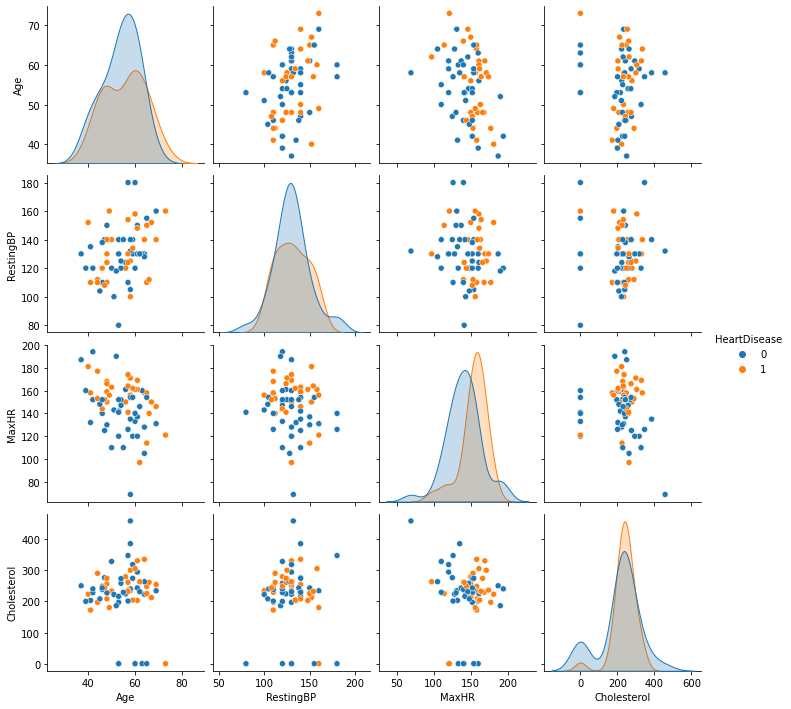

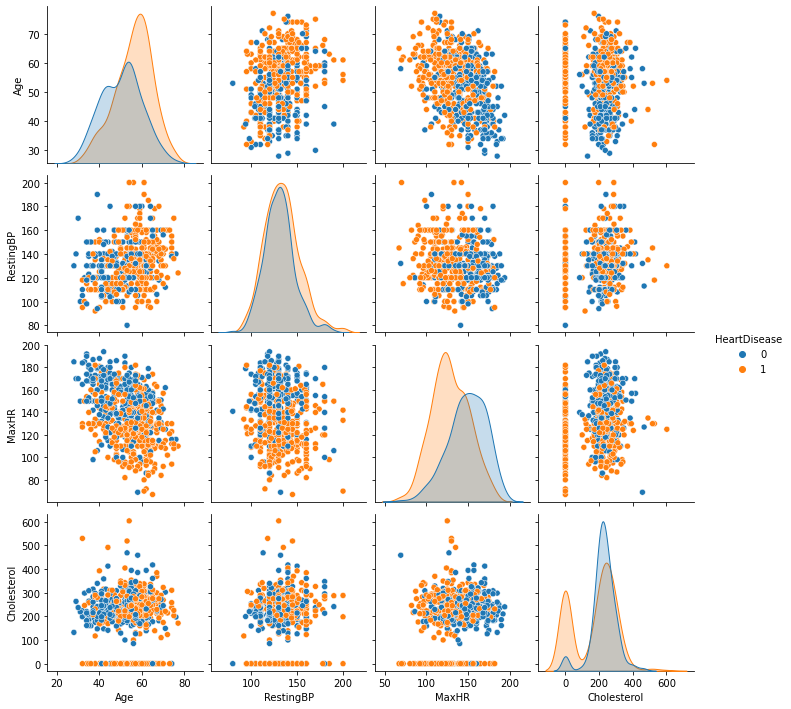

In [22]:
#間違いだけのデータフレーム作成
df_train_wrong=df_train.copy()
df_train_wrong=df_train_wrong.query('ACC==0')

#pairplotの作成,心臓病のありなしで色分け
sns.pairplot(df_train_wrong,vars=numeric_features+['Cholesterol'],hue='HeartDisease')
plt.savefig('./WrongAnswers/LR_dummy1.png')
sns.pairplot(df_train,vars=numeric_features+['Cholesterol'],hue='HeartDisease')
plt.show()

In [23]:
#それぞれの特徴量の係数
for i in range(len(X.columns)):
    print(X.columns[i],':',clf_LC.coef_[0,i])

Age_z : -0.07745113541786693
Sex : 0.9777777945114123
RestingBP_z : 0.030514104782417686
FastingBS : 0.629927077717571
MaxHR_z : -0.35649180783285456
ExerciseAngina : 1.0265866789892324
chol0 : 0.7290055178577214
chol1 : -0.7745082303366974
chol2 : -0.5991815525603094
Risk0 : -2.0629757847039656
Risk1 : -1.0379859243382064
Risk2 : 1.0224380511082054
Risk4 : 1.6141285421257854


In [13]:
#正答率と心臓病有り無しの関係
pd.crosstab(df_train['HeartDisease'],df_train['ACC'])

ACC,0,1
HeartDisease,,
0,38,245
1,40,319


## 正答率は上がるが、心臓病なしデータの正答率は下がる

In [14]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
df_train_wrong.head(100)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,H_risk,CholCat,ASY,ATA,TA+NAP,LVH,Normal,ST,chol0,chol1,chol2,chol3,Risk0,Risk1,Risk2,Risk3,Risk4,Age_z,RestingBP_z,MaxHR_z,y_pred,ACC
3,34,1,ASY,115,0,1,Normal,154,0,0.2,Up,1,Risk0,chol0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,-2.050938,-0.950457,0.674833,0,0
5,64,1,TA+NAP,140,335,0,Normal,158,0,0.0,Up,1,Risk0,chol3,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1.095304,0.438999,0.837400,0,0
10,56,1,ATA,124,224,1,Normal,161,0,2.0,Flat,0,Risk3,chol2,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0.256306,-0.450253,0.959326,1,0
12,61,0,ASY,130,330,0,LVH,169,0,0.0,Up,1,Risk0,chol3,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0.780680,-0.116784,1.284461,0,0
36,59,1,ASY,135,234,0,Normal,161,0,0.5,Flat,0,Risk3,chol2,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0.570930,0.161108,0.959326,1,0
39,66,0,ASY,178,228,1,Normal,165,1,1.0,Flat,1,Risk3,chol2,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1.305053,2.550971,1.121893,0,0
47,40,1,ASY,95,0,1,ST,144,0,0.0,Up,1,Risk0,chol0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,-1.421690,-2.062021,0.268414,0,0
48,59,1,TA+NAP,130,318,0,Normal,120,1,1.0,Flat,0,Risk3,chol2,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0.570930,-0.116784,-0.706992,1,0
59,37,1,TA+NAP,130,250,0,Normal,187,0,3.5,Down,0,Risk4,chol2,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,-1.736314,-0.116784,2.016015,1,0
72,47,0,TA+NAP,135,248,1,Normal,170,0,0.0,Flat,1,Risk2,chol2,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,-0.687567,0.161108,1.325103,0,0


In [ ]:
## 説明変数色々入れ忘れてた、、

In [19]:
df_train.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease', 'H_risk', 'CholCat', 'ASY', 'ATA', 'TA+NAP', 'LVH',
       'Normal', 'ST', 'chol0', 'chol1', 'chol2', 'chol3', 'Risk0', 'Risk1',
       'Risk2', 'Risk3', 'Risk4', 'Age_z', 'RestingBP_z', 'MaxHR_z', 'y_pred',
       'ACC'],
      dtype='object')

In [15]:
#特徴量と目的変数のカラム名
features = ['Age_z','Sex','RestingBP_z','FastingBS','MaxHR_z', 'ExerciseAngina','chol0','chol1', 'chol2', 'chol3','Risk0', 'Risk1', 'Risk2', 'Risk3', 'Risk4','ASY','ATA','TA+NAP','LVH','Normal','ST']
target = "HeartDisease"

In [16]:
#コレステロール値を含めてロジスティック回帰
#モデル作成
clf_LC = LogisticRegression(class_weight='balanced',max_iter=10000,C=5)


#5分割公差検証
#変数
X = df_train[features]
Y = df_train[target]

#交差検証
score_LC = cross_val_score(clf_LC, X, Y, cv=5)  

#正解率を出力する
print(f"スコア LC 交差バージョン: {score_LC}")
print("")

#平均値を出力する
print(f"平均値 LC 交差バージョン： {score_LC.mean()}")
print("")

スコア LC 交差バージョン: [0.85271318 0.88372093 0.90625    0.875      0.890625  ]

平均値 LC 交差バージョン： 0.8816618217054263



##　入れ忘れてたけどあまり変わらない,1個0.85があるから不安定かもしれない。

In [24]:
#予測結果の確認
#データをランダムに250個抽出してfitさせる
rng = np.random.default_rng()
train_index=rng.permutation(len(X))[:280]

clf_LC.fit(X.loc[train_index,:],Y[train_index])

#train以外のindexを持ってくる
all_index=np.arange(len(X))
mask=np.in1d(all_index,train_index,invert=True)
test_index=all_index[mask]

#テストスコアを確認
y_pred=clf_LC.predict(X.loc[test_index,:])
accuracy_score(Y[test_index],y_pred)

0.8839779005524862

In [25]:
#予測結果をデータフレームに格納
y_pred_all = clf_LC.predict(X)
df_train['y_pred']=y_pred_all

#正解の場合"1"になる列を作成
df_train['ACC']=0
for i in range(len(df_train)):
    if df_train.loc[i,'HeartDisease']==df_train.loc[i,'y_pred']:
        df_train.loc[i,'ACC']=1
    else:
        pass

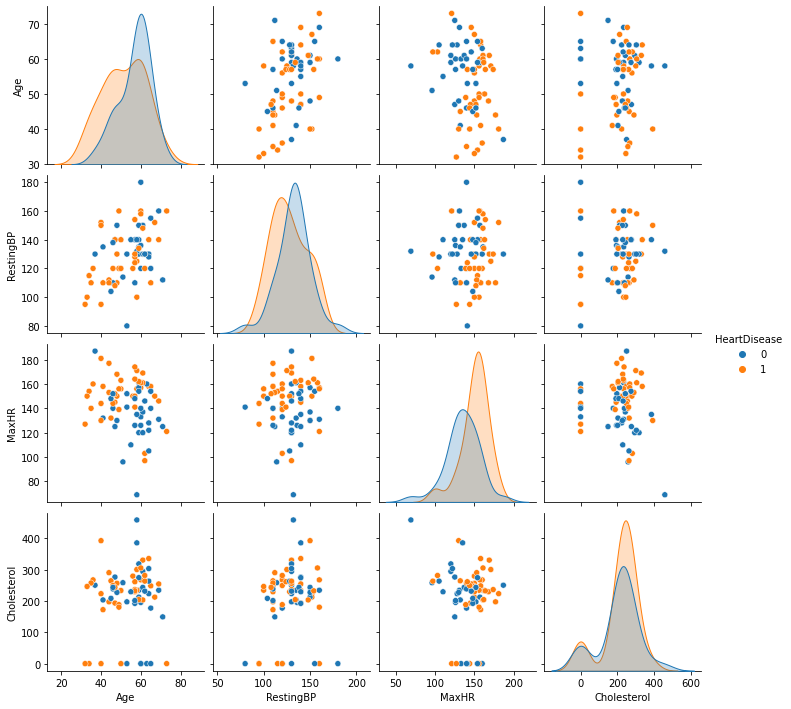

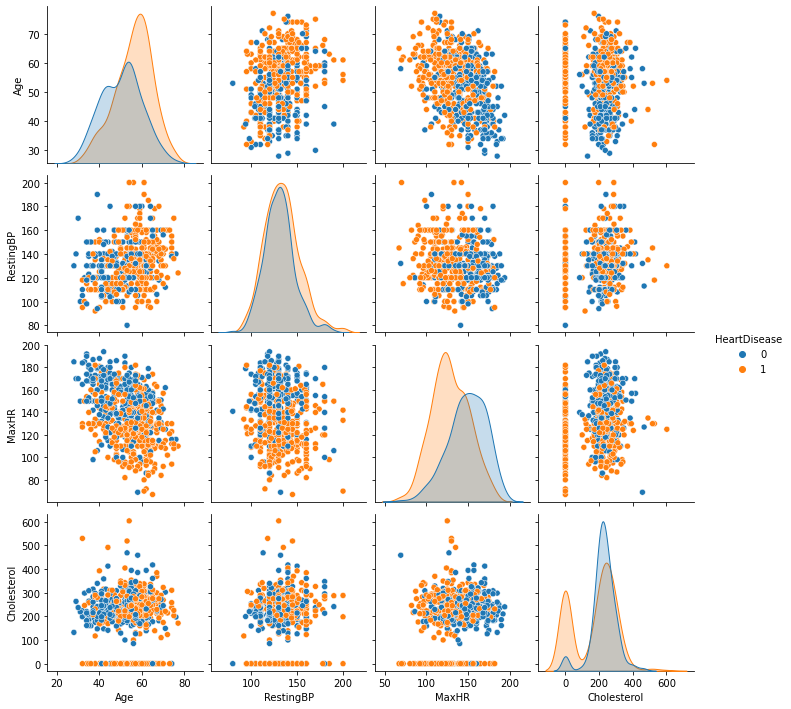

In [26]:
#間違いだけのデータフレーム作成
df_train_wrong=df_train.copy()
df_train_wrong=df_train_wrong.query('ACC==0')

#pairplotの作成,心臓病のありなしで色分け
sns.pairplot(df_train_wrong,vars=numeric_features+['Cholesterol'],hue='HeartDisease')
plt.savefig('./WrongAnswers/LR_dummy1.png')
sns.pairplot(df_train,vars=numeric_features+['Cholesterol'],hue='HeartDisease')
plt.show()

In [27]:
#それぞれの特徴量の係数
for i in range(len(X.columns)):
    print(X.columns[i],':',clf_LC.coef_[0,i])

Age_z : 0.2481406681004381
Sex : 1.569997764991216
RestingBP_z : 0.14724537288052045
FastingBS : 1.0486259889154133
MaxHR_z : -0.4353035342647682
ExerciseAngina : 0.3762758674320285
chol0 : 0.44297926720919134
chol1 : -0.061262305747227255
chol2 : 0.15309537333857215
chol3 : -0.535348046035975
Risk0 : -2.572288815721112
Risk1 : -0.704440525484263
Risk2 : 1.4531904829603581
Risk3 : 0.20604877376161024
Risk4 : 1.616954373247971
ASY : 1.2367908051257845
ATA : -0.9968668832398707
TA+NAP : -0.24045963312135005
LVH : -0.15638399432705846
Normal : 0.28889701793158296
ST : -0.13304873483996146


## chol1の係数がほぼ0になった・・コレステロールが正常値であることはASY,ATA,TA+NAP,LVH,Normal,STのどれかと意味合いがかぶっているみたい

## Risk3の係数が小さいのが気になる

In [28]:
pd.crosstab(df_train['Risk3'],df_train['HeartDisease'])

HeartDisease,0,1
Risk3,,
0,233,183
1,50,176


In [29]:
pd.crosstab(df_train_wrong['Risk3'],df_train['HeartDisease'])

HeartDisease,0,1
Risk3,,
0,15,25
1,18,15


In [32]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
df_train_wrong.head(100)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,H_risk,CholCat,ASY,ATA,TA+NAP,LVH,Normal,ST,chol0,chol1,chol2,chol3,Risk0,Risk1,Risk2,Risk3,Risk4,Age_z,RestingBP_z,MaxHR_z,y_pred,ACC
3,34,1,ASY,115,0,1,Normal,154,0,0.2,Up,1,Risk0,chol0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,-2.050938,-0.950457,0.674833,0,0
5,64,1,TA+NAP,140,335,0,Normal,158,0,0.0,Up,1,Risk0,chol3,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1.095304,0.438999,0.837400,0,0
12,61,0,ASY,130,330,0,LVH,169,0,0.0,Up,1,Risk0,chol3,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0.780680,-0.116784,1.284461,0,0
36,59,1,ASY,135,234,0,Normal,161,0,0.5,Flat,0,Risk3,chol2,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0.570930,0.161108,0.959326,1,0
47,40,1,ASY,95,0,1,ST,144,0,0.0,Up,1,Risk0,chol0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,-1.421690,-2.062021,0.268414,0,0
48,59,1,TA+NAP,130,318,0,Normal,120,1,1.0,Flat,0,Risk3,chol2,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0.570930,-0.116784,-0.706992,1,0
55,60,1,ASY,136,195,0,Normal,126,0,0.3,Up,0,Risk1,chol1,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0.675805,0.216686,-0.463140,1,0
58,51,0,ASY,114,258,1,LVH,96,0,1.0,Up,0,Risk1,chol2,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,-0.268068,-1.006035,-1.682397,1,0
59,37,1,TA+NAP,130,250,0,Normal,187,0,3.5,Down,0,Risk4,chol2,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,-1.736314,-0.116784,2.016015,1,0
81,64,1,ASY,130,223,0,ST,128,0,0.5,Flat,0,Risk3,chol2,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1.095304,-0.116784,-0.381857,1,0
